<DIV ALIGN=CENTER>

# Introduction to Probabilistic Programming
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we build on 

-----



In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

## Sample Model and Analysis

-----

In [2]:
# We define a simple function to fit.

m_true = 0.5
b_true = 0.25

np.random.seed(23)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = b_true + m_true * x - sigma * np.random.randn(len(x))

    # A non-linear equation
    # y = b_true + m_true * x - sigma * np.random.randn(len(x)) - sigma * x **2

    return(x, y)

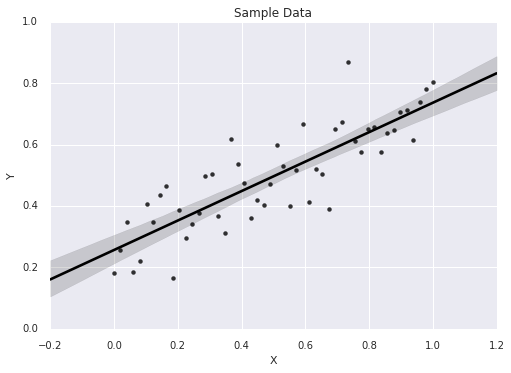

In [3]:
# Obtain sample data and plot data and model fit

x, y = theModel(num = 50)

ax = sns.regplot(x, y, fit_reg=True, color='black', label="Data")
ax.set(xlabel='X', ylabel='Y', title='Sample Data')
sns.despine(offset=5, trim=True)

In [4]:
import statsmodels.formula.api as smf

# Encapsulate our test data
df = pd.DataFrame({'x': x, 'y': y})

# Implement simple regression: Result ~ Input

# First we fit slope and intercept
result = smf.ols(formula='y ~ x', data=df).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     116.3
Date:                Mon, 28 Mar 2016   Prob (F-statistic):           2.01e-14
Time:                        22:09:39   Log-Likelihood:                 49.021
No. Observations:                  50   AIC:                            -94.04
Df Residuals:                      48   BIC:                            -90.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2567      0.026      9.944      0.000         0.205     0.309
x              0.4798      0.044     10.786      0.000         0.390     0.569
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.782
Skew:                           0.303   Prob(JB):                        0.676
Kurtosis:                       3.095   Cond. No.                         4.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----

### Bayesian Analysis

-----

In [5]:
# The following example follows the first case study from pymc3 documentation
# http://pymc-devs.github.io/pymc3/getting_started/#case-study-1-stochastic-volatility

import pymc3 as pm

In [6]:
n_samples = 10000

with pm.Model() as linear_model:
    
    # First, define stohastic model variables
    intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
    slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('sigma', mu = 1., sd = 2.0) #beta=10, testval=1.)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept + slope* x
    
    # Sample values (likelihood)
    likelihood = pm.Normal('y', mu=y_exp, sd=sigma, observed=y)

Applied interval-transform to Intercept and added transformed Intercept_interval to model.


-----

### Trace Analysis

-----

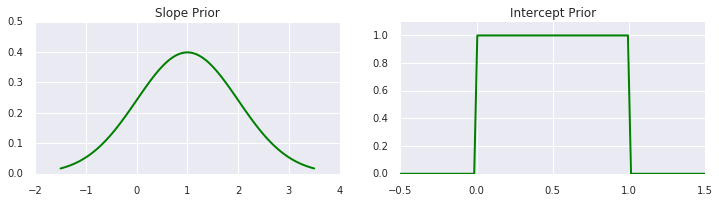

In [7]:
import scipy.stats as sts

plt.figure(figsize=(12, 6))
plt.subplot(221)
x_pts = np.linspace(-1.5, 3.5, 100)
rv = sts.norm(loc=1.0, scale=1.0)
plt.plot(x_pts, rv.pdf(x_pts), 'g-', lw=2)
plt.ylim(0.0, 0.5)
plt.title('Slope Prior')

plt.subplot(222)
x_pts = np.linspace(-0.5, 1.5, 100)
rv = sts.uniform(loc=0.0, scale=1.0)
plt.plot(x_pts, rv.pdf(x_pts), 'g-', lw=2)
plt.title('Intercept Prior')
plt.ylim(0.0, 1.1)
sns.despine(offset=5, trim=True)
plt.show()

-----

### Sample Posterior

-----

In [8]:
step = pm.NUTS(model = linear_model)

In [9]:
trace = pm.sample(n_samples, step, 
                  model = linear_model,
                  progressbar = True)

 [-----------------100%-----------------] 10000 of 10000 complete in 12.4 sec

-----

### Trace Analysis

-----

In [10]:
df_trace = pm.trace_to_dataframe(trace)
df_trace.describe()

,Intercept,Intercept_interval,Slope,sigma
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.259148,-1.097179,0.487435,0.212384
std,0.065665,0.728783,0.122943,1.057743
min,0.000002,-13.054064,-1.182707,0.055042
25%,0.235630,-1.176792,0.448799,0.090076
50%,0.255129,-1.071440,0.483313,0.098015
75%,0.275360,-0.967597,0.518106,0.109424
max,0.963662,3.277868,2.145333,30.407663


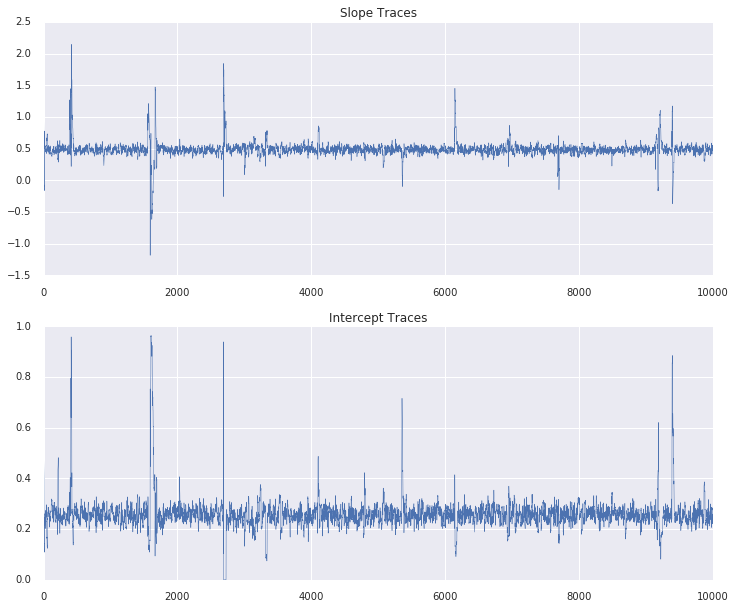

In [11]:
plt.figure(figsize=(12, 10))
sns.set_style('darkgrid')

plt.subplot(211)
plt.plot(df_trace['Slope'], lw=0.5)
plt.title('Slope Traces')

plt.subplot(212)
plt.plot(df_trace['Intercept'], lw=0.5)
plt.title('Intercept Traces')
sns.despine(offset = 5, trim=False)
plt.show()

-----

### Posterior Distributions

-----

In [12]:
n_burn = 1000

print('Slope Trace Values:')
print(trace['Slope'][-10:])

print('\nSlope Trace  statistics:')
mu = np.mean(trace['Slope']) ; sigma = np.std(trace['Slope'])
print('Full Sample:  Mean = {0:4.3f}, STD = {1:4.3f}'.format(mu, sigma))
mu = np.mean(trace['Slope'][-n_burn:]) ; sigma = np.std(trace['Slope'][-n_burn:])
print('Last {0}:  Mean = {1:4.3f}, STD = {2:4.3f}'.format(n_burn, mu, sigma))

print('\nIntercept Trace Values:')
print(trace['Intercept'][-10:])

print('\nIntercept Trace statistics:')
mu = np.mean(trace['Intercept']) ; sigma = np.std(trace['Intercept'])
print('Full Sample:  Mean = {0:4.3f}, STD = {1:4.3f}'.format(mu, sigma))
mu = np.mean(trace['Intercept'][-n_burn:]) ; sigma = np.std(trace['Intercept'][-n_burn:])
print('Last {0}:  Mean = {1:4.3f}, STD = {2:4.3f}'.format(n_burn, mu, sigma))

Slope Trace Values:
[ 0.47457599  0.5543285   0.52288724  0.55444986  0.4775731   0.49680632
  0.47310408  0.46103996  0.50277318  0.4966129 ]

Slope Trace  statistics:
Full Sample:  Mean = 0.487, STD = 0.123
Last 1000:  Mean = 0.488, STD = 0.141

Intercept Trace Values:
[ 0.23449373  0.22111606  0.2203476   0.22224314  0.24263846  0.25842327
  0.24261515  0.25918616  0.23449798  0.23708443]

Intercept Trace statistics:
Full Sample:  Mean = 0.259, STD = 0.066
Last 1000:  Mean = 0.263, STD = 0.083


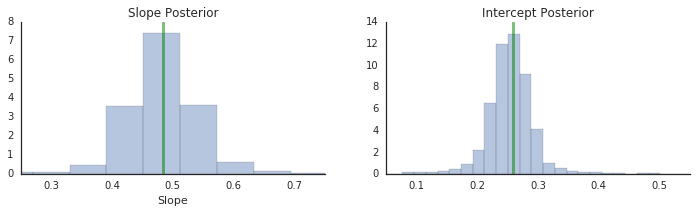

In [13]:
plt.figure(figsize=(12, 6))
sns.set_style('white')

plt.subplot(221)
sns.distplot(df_trace['Slope'][n_burn:], kde=False, norm_hist=True, bins=50)

mu = np.mean(df_trace['Slope'][n_burn:])
plt.axvline(mu, linestyle='-', color='g', lw = 3, alpha=0.5)

plt.xlim(0.25, 0.75)
plt.title('Slope Posterior')

plt.subplot(222)
sns.distplot(trace['Intercept'][n_burn:], kde=False, norm_hist=True, bins=50)

mu = np.mean(df_trace['Intercept'][n_burn:])
plt.axvline(mu, linestyle='-', color='g', lw = 3, alpha=0.5)

plt.xlim(0.05, 0.55)
plt.title('Intercept Posterior')
sns.despine()
plt.show()


-----

### Posterior Distribution Surfaces

-----

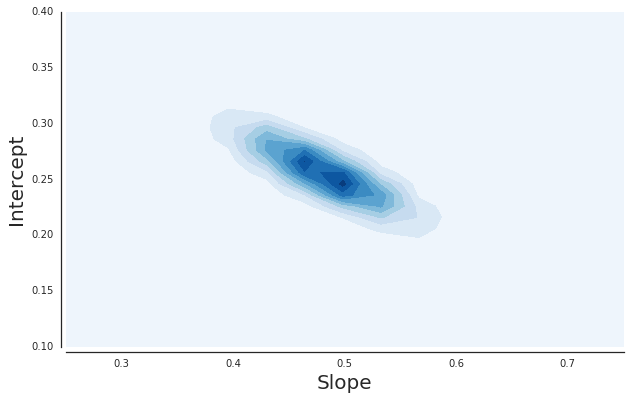

In [14]:
plt.figure(figsize=(10, 6))
sns.set_style('white')
sns.kdeplot(df_trace.Slope, df_trace.Intercept, cmap='Blues', shade=True)
plt.xlabel('Slope', fontsize=20)
plt.xlim(0.25, 0.75)
plt.ylabel('Intercept', fontsize=20)
plt.ylim(0.1, 0.4)

sns.despine(offset=5, trim=False)
plt.show()

-----

### Autocorrelation

-----

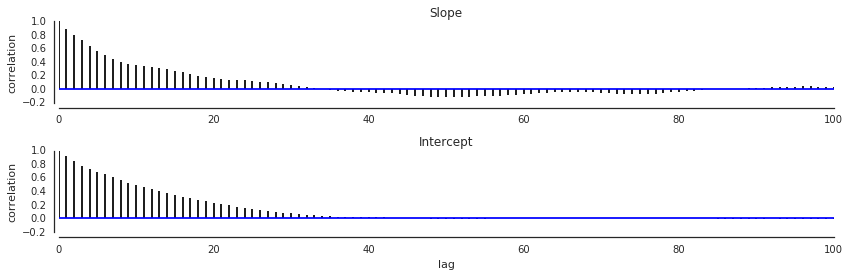

In [15]:
sns.set_style('white')

pm.autocorrplot(trace, varnames=['Slope', 'Intercept'])
sns.despine(offset=5, trim = True)
plt.tight_layout()

-----

## PYMC3  Example

-----

In [16]:
n_burn = 10000
n_samples = 20000

with pm.Model() as linear_model:
    
    # First, define stohastic model variables
    intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
    slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('sigma', mu = 1., sd = 2.0) #beta=10, testval=1.)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept + slope* x
    
    # Sample values (likelihood)
    likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(n_samples, step=step, start=start)

Applied interval-transform to Intercept and added transformed Intercept_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 13.0 sec

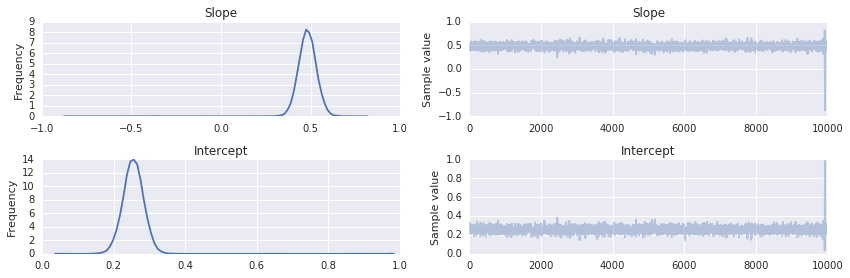

In [17]:
sns.set_style('darkgrid')
pm.traceplot(trace[-n_burn:], ['Slope', 'Intercept'])
plt.show()

In [18]:
pm.summary(trace[-n_burn:], ['Slope', 'Intercept'])


Slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.482            0.058            0.001            [0.389, 0.580]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.388          0.451          0.482          0.515          0.579


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.256            0.036            0.001            [0.199, 0.311]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.199          0.237          0.255          0.274          0.310



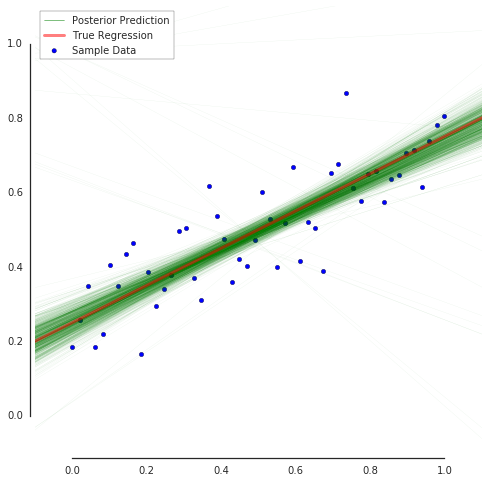

In [19]:
n_smpls = 1000

sns.set_style('white')
plt.figure(figsize=(8,8))

plt.scatter(x, y, label = 'Sample Data')

xl = -0.25 ; xh = 1.25

for m, b in zip(trace['Slope'][-n_smpls:], trace['Intercept'][-n_smpls:]):
    yl = m * xl + b ; yh = m * xh + b
    plt.plot((xl, xh), (yl, yh), color='g', lw=0.25, alpha = 0.1)

# Replot last one to get legebnd label
plt.plot((xl, xh), (yl, yh), color='g', lw=0.5, \
         label = 'Posterior Prediction')

yl = b_true + m_true * xl ; yh = b_true + m_true * xh
plt.plot((xl, xh), (yl, yh), color='r', lw=3, alpha = 0.5, label='True Regression')

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left', frameon=True)
sns.despine(offset=5, trim=True)
plt.show()

-----

### Student Activity

In the preceding cells, we introduced several basic graph concepts,
including XX YY ZZ. Now
that you have run the Notebook, go back and make the following changes
to see how the results change.

1. Change 
2. Replace 
3. Try using 

-----